In [1]:
import pickle as pkl
import model
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as tt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
dataset_name = 'MNIST'
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
} if dataset_name == 'MNIST' else {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
n_class = 10


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = self.make_feature()
        self.classifier = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def make_feature(self):
        c_in = 28 * 28
        config = [512, 256, 128]
        layers = []
        for i in range(len(config)):
            layers += [nn.Linear(c_in, config[i]), nn.LeakyReLU(negative_slope=0.2), nn.Dropout(p=0.3)]
            c_in = config[i]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.features(x)
        out = self.classifier(out)
        return out


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = self.make_feature()
        self.out = nn.Sequential(
            nn.Linear(512, 28 * 28),
            nn.Tanh(),
        )

    def make_feature(self):
        c_in = 100
        config = [128, 256, 512]
        layers = []
        for i in range(len(config)):
            layers += [nn.Linear(c_in, config[i]), nn.LeakyReLU(negative_slope=0.2), nn.Dropout(p=0.3)]
            c_in = config[i]
        return nn.Sequential(*layers)

    def forward(self, z):
        out = self.features(z)
        out = self.out(out).view(z.size(0), 28, 28)
        return out

class KDE(nn.Module):
    def __init__(self, samples):
        self.samples = samples
#         self.H = np.eye(samples.shape[1])
        self.H = self.estimate_H()
        self.H_inv = self.H.copy()
        self.H_inv[self.H != 0] = 1/self.H[self.H != 0]
    
    def probability(self, tests):
        tests = tests.copy()
        samples = self.samples.copy()
        dim = tests.shape[1]
        n_tests = tests.shape[0]
        n_samples = samples.shape[0]
        tests = np.expand_dims(tests, axis=0).transpose((0, 2, 1))
        samples = np.expand_dims(samples, axis=2)
        
        delta = tests - samples
        M = np.array([np.diag(-1./2*delta[i].T@self.H_inv@delta[i]) for i in range(delta.shape[0])])
        M_max = M.max(axis=0, keepdims=True)
        M = M - M_max
        # Estimatation of log likelihood missing (2pi)^(d/2) but have no effection to result
        probs = np.log(np.sum(np.exp(M), axis=0)) + M_max.squeeze() - np.log(n_samples)
        return -probs
    
    def estimate_H(self):
        n, dim = self.samples.shape
        std = np.std(self.samples, axis=0)
        H = n**(-1/(dim+4))*np.diag(std)**2
        print(H)
        return H

cuda


In [3]:
with open('./model/gan/discriminator.sav', 'rb') as d_file:
    discriminator = pkl.load(d_file)
with open('./model/gan/generator.sav', 'rb') as g_file:
    generator = pkl.load(g_file)

[[2.51493906e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.01665384e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.12658609e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.50942452e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.34777946e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.37608532e-04]]


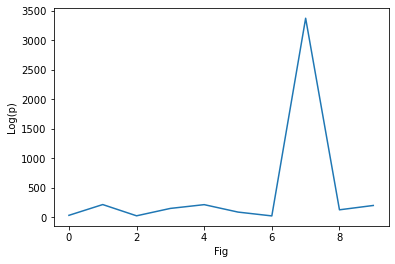

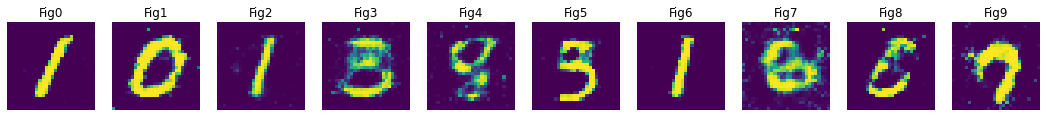

In [4]:
generator.eval().to('cpu')
n_samples = 1000
n_tests = 10

z = torch.from_numpy(np.random.normal(0, 1, size=(n_samples, 100))).float()
gen_img = generator(z).detach().numpy()
kde = KDE(gen_img.reshape(n_samples, -1))
z = torch.from_numpy(np.random.normal(0, 1, size=(n_tests, 100))).float()
test_img = generator(z).detach().numpy()
log_probs = kde.probability(test_img.reshape(n_tests, -1))

fig1 = plt.figure()
plt.plot(log_probs)
plt.xlabel('Fig')
plt.ylabel('Log(p)')
fig2, axes = plt.subplots(1, n_tests)
fig2.set_size_inches(18.5, 10.5)
for i in range(n_tests):
    axes[i].imshow(test_img[i])
    axes[i].set_title('Fig{}'.format(i))
    axes[i].axis(False)

plt.show()